In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate as integrate

In [2]:
# cчитывание координат точек из заранее сгенерированного .txt файлика
# каждая строка в файле вида: "n x1 y1 x2 y2 (x3 y3)", где n - количество опорных точек сплайна 
# координаты опорных точек далее хранятся в списке кортежей: [(x1, y1), (x2,y2) (, (x3, y3))]

file = open('координаты.txt', 'r')
data_list = file.readlines()
for i in range(len(data_list)):
    data_list[i] = list(map(int, data_list[i].split(' ')))
file.close()

coords = []
for line in data_list:
    k = []
    for i in range(line[0]):
        k.append((line[2*i+1],line[2*i+2]))
    coords.append(k)

In [3]:
# функция вычисления коэффициентов и собственной длины сплайна по опорным

def find_coeff(coord_line):
    
    x = [coord_line[i][0] for i in range(len(coord_line))]
    y = [coord_line[i][1] for i in range(len(coord_line))]
    
    if len(x) == 2:
        t_0 = 0.
        t_max = np.linalg.norm([x[1]-x[0], y[1]-y[0]])
        
        a = np.array([[1., t_0],
                      [1., t_max]])
    else:
        t_0 = 0.
        t_1 = np.linalg.norm([x[1]-x[0], y[1]-y[0]])
        t_max = t_1 + np.linalg.norm([x[2]-x[1], y[2]-y[1]])
        a = np.array([[1., t_0, t_0**2],
                      [1., t_1, t_1**2],
                      [1., t_max, t_max**2]])

    p_x = scipy.linalg.solve(a, x) 
    p_y = scipy.linalg.solve(a, y)
    return (p_x, p_y,t_max)


In [4]:
# Spl - массив, каждая строка которого - коэффициенты p_x, p_y i-го полинома и t_max - собственная длина сплайна
# здесь хранится запись всех сплайнов, образующих карту

Spl = []
for i in range(len(coords)):
    Spl.append(find_coeff(coords[i]))

In [5]:
# функции вычисления значений полинома в точке t (отдельно по осям x и y), p_line - строка из Spl

def P_x(p_line, t):
    
    if len(p_line[0]) == 2:
        return p_line[0][0]+p_line[0][1]*t
    else:
        return p_line[0][0]+p_line[0][1]*t+p_line[0][2]*t**2
    
def P_y(p_line, t):
    
    if len(p_line[0]) == 2:
        return p_line[1][0]+p_line[1][1]*t
    else:
        return p_line[1][0]+p_line[1][1]*t+p_line[1][2]*t**2
    

In [6]:
# функция вычисления натурального параметра s в точке t для i-го сплайна карты

def s(i,t):
    if len(Spl[i][0]) == 2:
        return t
    
    x = np.arange(0.0, t+0.1, max(0.1, t/10))
    y = f(i, x)
    rez = integrate.simps(y, x)
    return rez

# вспомогательная функция, возвращает список значение подинтегральной функции в точках разбиения
def f(i, x):
    lst = []
    for h in x:
        lst.append(math.sqrt((Spl[i][0][1]+2*Spl[i][0][2]*h)**2 + (Spl[i][1][1]+2*Spl[i][1][2]*h)**2))
    return lst

In [7]:
# считывание "функции склейки полиномов" из заранее сгенерированного файлика .txt 
# каждая строка в файле вида: "n1 (n2 n3 и т.д)", где n* - номер сплайна, который является продолжением текущего 
# на перекрестках продолжением могут выступать несколько сплайнов, если n1 = -1 -- "дорога упирается в тупик"

file = open('склейка.txt', 'r')
connects = file.readlines()
for i in range(len(connects)):
    connects[i] = list(map(int, connects[i].split(' ')))
file.close()

In [8]:
# функция скачка на новый сплайн, возвращает номер нового сплайна, расстояние "скачка" и обнуляет параметр сплайна t 

def jump(i, j=0):
    i_new = connects[i][j]
    if i_new == -1:
        return (-1, 0, 0)
    x_0 = coords[i][-1][0]
    y_0 = coords[i][-1][1]
    x_1 = coords[i_new][0][0]
    y_1 = coords[i_new][0][1]
    
    dist = np.linalg.norm([x_1 - x_0, y_1 - y_0])
    return (i_new, dist, 0)

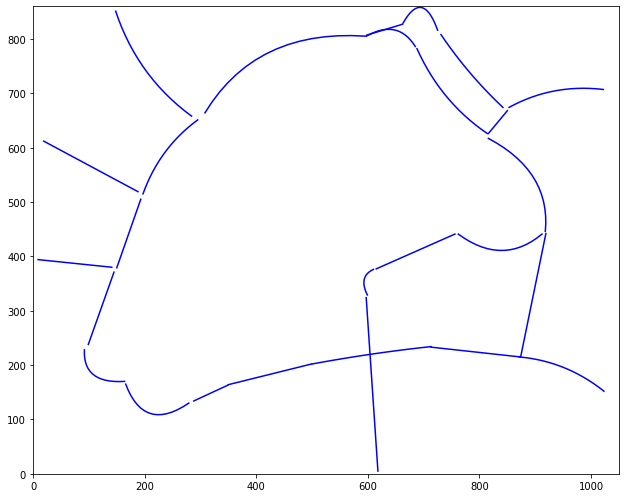

In [11]:
# тестовый блок, рисует, как сейчас выглядит карта

plt.figure(figsize=(10.5, 8.6))
plt.axis([0, 1050, 0, 860])

for i in range(len(coords)):
    t = np.arange(0.0, Spl[i][-1]+1, Spl[i][-1]/15)
    x_val = [P_x(Spl[i], h) for h in t ]
    y_val = [P_y(Spl[i], h) for h in t ]
    plt.plot(x_val, y_val, 'blue')

plt.show()

In [12]:
# тестовая функция движения на расстояние km от начала i-го сплайна, возвращает номер сплайна и значение параметра t на нём
# не нужна непосредственно в реализации карты, просто проверяет корректность работы

def go(i, km):
    now = 0
    t = 0
    prev = 0
    while (now < km):
        while (t < Spl[i][2]) and (now < km):
            t+=1
            now = s(i,t)+prev
        if now >= km:
            return (i, t)
        
        i_new , dist, t = jump(i)
        if i_new == -1: 
            return (i, Spl[i][2])
        i = i_new
        prev = now + dist    

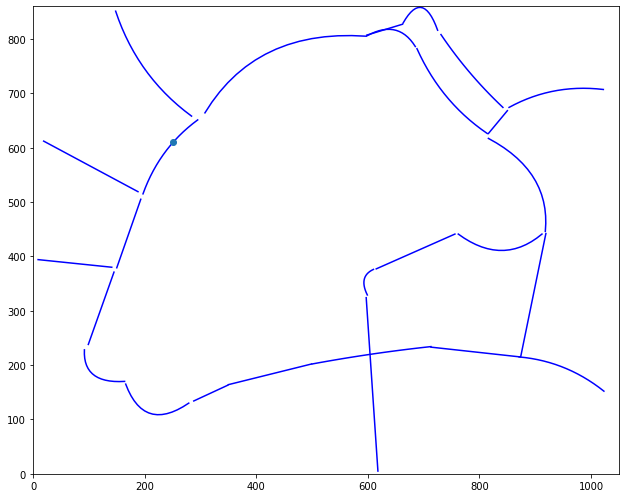

In [14]:
# тестовый блок, передавая в go произвольные координаты можно посмотреть, куда уедет наша точка

i_0, t0 = go(0, 420)
plt.figure(figsize=(10.5, 8.6))

for i in range(len(coords)):
    t = np.arange(0.0, Spl[i][-1]+1, Spl[i][-1]/15)
    x_val = [P_x(Spl[i], h) for h in t ]
    y_val = [P_y(Spl[i], h) for h in t ]
    plt.plot(x_val, y_val, 'blue')
    
    
plt.axis([0, 1050, 0, 860])
plt.plot(P_x(Spl[i_0], t0), P_y(Spl[i_0], t0), 'o')